# Setup

## Start Hadoop Services

1. Open a console and start the Hadoop services:
> start-dfs.sh  
> start-yarn.sh 

- Open the webpages associated with Hadoop:
    - [Hadoop Control Panel](http://localhost:8088/cluster)
    - [HDFS Directory](http://localhost:50070/explorer.html#/)
    - If the HDFS directory doesn't work, reformat HDFS and rerun start-dfs.sh. I hate this.
> hdfs namenode -format

## Start Spark Services

1. Open a console and start the Spark master and slaves:
> start-master.sh  
> start-slaves.sh

- Open the webpages associated with Spark:
    - [Spark Master](http://localhost:8080/)
    - [Spark Job](http://localhost:4040/stages/)

## Imports

In [1]:
import pyspark
import numpy as np

from sipl.image import PILImageIn, ImageToPIL, dstack
from sipl.hdfs import hdfs_rm, hdfs_exists, HDFSToRDD, RDDToHDFS
from sipl.spark import ImageToRDD, RDDToImage

## PIL Inline Display Function

In [2]:
# Register image display with IPython
# http://nbviewer.ipython.org/gist/deeplook/5162445
from io import BytesIO
from IPython.core import display
from PIL import Image

def display_pil_image(im):
   b = BytesIO()
   im.save(b, format='png')
   data = b.getvalue()
   ip_img = display.Image(data=data, format='png', embed=True)
   return ip_img._repr_png_()

png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)

# Code Starts Here

## Create a Spark context

In [3]:
sc = pyspark.SparkContext(master="spark://pootar:7077",
                          appName="Spark Image Distribution")

## Load data

In [5]:
filename = "data/cheetah.jpg"
hdfsFilename = "hdfs://pootar:9000/cheetahNone2.rdd"

### from disk

In [6]:
imageIn = PILImageIn()(filename)
rdd = ImageToRDD(context=sc)(imageIn)
rdd.cache()
# Send the data to HDFS if needed
RDDToHDFS(filename=hdfsFilename)(rdd)

### or from hdfs

In [7]:
rdd = HDFSToRDD(context=sc)(hdfsFilename)
rdd.cache()

PythonRDD[6] at RDD at PythonRDD.scala:43

In [8]:
from sipl.image import Image as SImage
r = sc.textFile(hdfsFilename)
def load(x):
    SImage.loads(x)
r2 = r.map(load)

In [9]:
sc.defaultParallelism

8

### A small function to change something about the image

In [10]:
def change(x):
    size = x._dimData[0]["proc_grid_rank"] + 1
    rank = x._dimData[0]["proc_grid_size"]
    factor = float(size) / rank
    return (x*factor).astype(np.uint8)

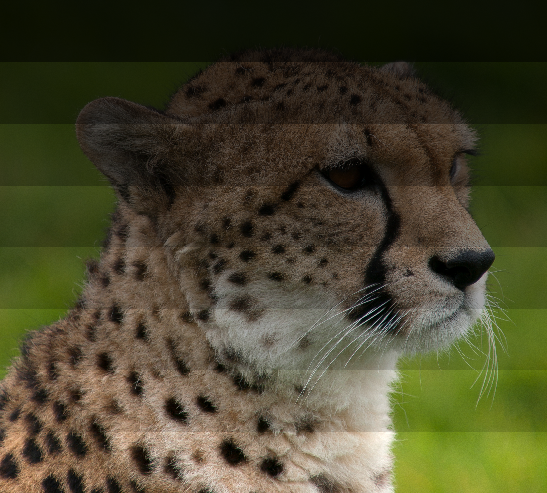

In [11]:
ImageToPIL(decimationFactor=4)(RDDToImage()(rdd.map(change)))

In [13]:
import time
def random_color_channel(x):
    r = x[:, :, 0] + int((time.time()*100000) % 255)
    g = x[:, :, 1] + int((time.time()*100000) % 255)
    b = x[:, :, 2] + int((time.time()*100000) % 255)
    return dstack((r, g, b))

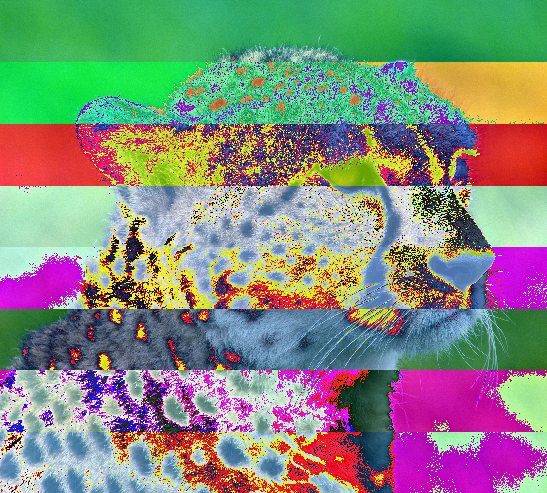

In [14]:
ImageToPIL(decimationFactor=4)(RDDToImage()(rdd.map(random_color_channel)))

### Stop the Spark Context

In [ ]:
# sc.stop()